In [ ]:
#Spam Classifier Using Lemmatization and TFIDF

In [ ]:
import pandas as pd
from sklearn import metrics
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from time import perf_counter


In [ ]:
from google.colab import files
files=files.upload()

Saving spam_ham.csv to spam_ham.csv


In [ ]:
mail_messages=pd.read_csv('spam_ham.csv')

In [ ]:
mail_messages.head()


,label,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
mail_messages=mail_messages.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

In [ ]:
mail_messages.rename(columns = {'label':'Label', 'message':'Message'}, inplace = True)

In [ ]:
mail_messages.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
mail_messages['Label'].value_counts()

ham     4825
spam     747
Name: Label, dtype: int64

<Axes: >

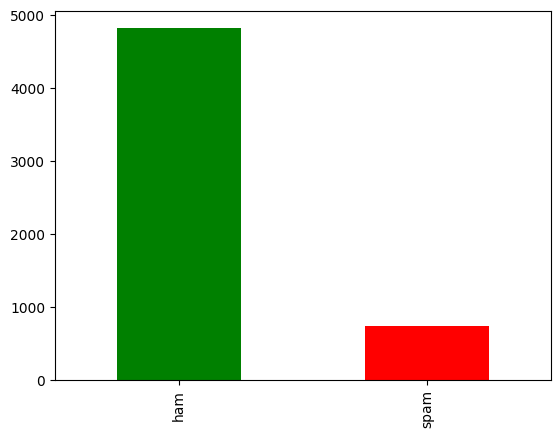

In [ ]:

mail_messages['Label'].value_counts().plot.bar(color = ["g","r"])

In [ ]:
mail_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Label    5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
#Data cleaning and preprocessing
# LEMMATIZATION
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(mail_messages)):
    review = re.sub('[^a-zA-Z]', ' ', mail_messages['Message'][i])
    review = review.lower()
    review = review.split()

    review = [lemmatizer.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Creating the TF IDF(Term frequency and Inverse document frequency) model
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(max_features=5572)
X = cv.fit_transform(corpus).toarray()


In [ ]:
#converting the labels,spam or ham as 1 or 0
y=pd.get_dummies(mail_messages['Label'])
y=y.iloc[:,1].values

In [ ]:
# Train Test Split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
print(f"Rows in X train set: {len(X_train)}\nRows in X test set: {len(X_test)}\nRows in Y train set: {len(y_train)}\nRows in Y test set: {len(y_test)}\n")


Rows in X train set: 4457
Rows in X test set: 1115
Rows in Y train set: 4457
Rows in Y test set: 1115



In [ ]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0},
}

In [ ]:
for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 19.73 sec
MultinomialNB        trained in 0.1 sec


In [ ]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test, y_test),model["perf"]])

In [ ]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy (test set)', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy (test set)', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy (test set),Training time (sec)
0,Random Forest,0.977578,19.73
1,MultinomialNB,0.965022,0.10


In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import fbeta_score, f1_score
from sklearn.metrics import roc_auc_score

In [ ]:
model_stats = []
for name, model in models.items():

    y_pred = model["model"].predict(X_test)
    model_stats.append([name, model["model"].score(X_test, y_test),model["perf"],precision_score(y_test, y_pred), recall_score(y_test, y_pred),f1_score(y_test, y_pred),fbeta_score(y_test, y_pred, beta = 2), roc_auc_score(y_test, y_pred)])
    print(f'{name} appended to stats')        #only to track the progress

Random Forest appended to stats
MultinomialNB appended to stats


In [ ]:
df_stats = pd.DataFrame(model_stats)
df_stats.columns = ['Model', 'Accuracy (test set)', 'Training time (sec)', 'Precision', 'Recall','F1 score', 'F2 score', 'ROC-AUC score']
df_stats.sort_values(by = 'Accuracy (test set)', ascending = False, inplace=True)
df_stats.reset_index(drop = True, inplace=True)
df_stats

,Model,Accuracy (test set),Training time (sec),Precision,Recall,F1 score,F2 score,ROC-AUC score
0,Random Forest,0.977578,19.73,0.993007,0.855422,0.919094,0.879802,0.927184
1,MultinomialNB,0.965022,0.10,1.000000,0.765060,0.866894,0.802781,0.882530


In [ ]:
df_stats.to_csv('TFIDF using Lemma.csv')

In [ ]:
#Using Confusion matrix and Evaluating the accuracy
from sklearn.metrics import confusion_matrix
confusion_m=confusion_matrix(y_test, y_pred)


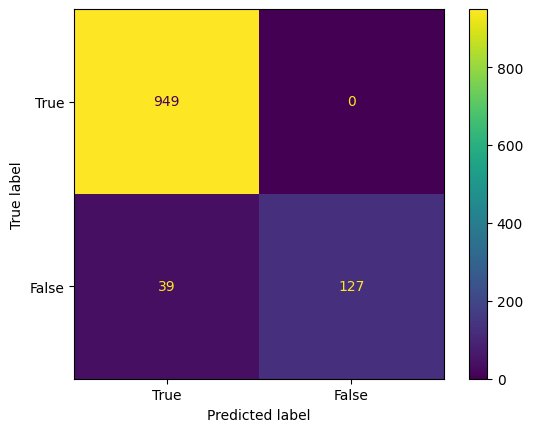

In [ ]:
# plotting the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_m,display_labels = [True, False])
disp.plot()
plt.show()